# Practical Session : Image segmentation

The objective of this practical session is to perform the segmentation of noisy images of disks using the Context Aggregation Network introduced by Yu and Koltun in 2015.

Yu, F., & Koltun, V. (2015). Multi-scale context aggregation by dilated convolutions. arXiv preprint arXiv:1511.07122.

To run the notebook using Google Colab:
1. Go to Google Colab: https://colab.research.google.com/
2. File -> Upload Notebook
3. Upload the notebook
4. In Edit -> Notebook Setting, select a gpu as hardware accelerator


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Data generation

The code below allows to simulate images of disks with distinct gray levels. The images are $64 \times 64$ pixels images encoded on 8 bites. An average of $\theta = 5$ disks are randomly generated in each image. The radii of the disks are sampled from independent normal distributions with mean $4$ pixels and standard deviation $0.5$ pixel. The gray level of each disk is drawn randomly from an uniform distribution between $15$ and $200$.
White noise with standard deviation $\sigma = 30$ pixels is then added to the images.

In [2]:
class Data_Generator:

    """
    Class used to generate synthetic images

    Attributes
    ----------

    nx, ny: ints
       shape of the synthetic image
    theta: float
       average number of disks per image
    rmean: float
       average radius of the disks
    rstd: float
       standard deviation of the radii
    vmin, vmax: ints
       minimal/maximal gray level of the disks
    sigma: float
       standard deviation of the noise
    img: numpy array
       synthetic image
    img_truth: numpy array
       ground truth image
    ndisks: int
       number of disks
    """

    def __init__(self, size, theta, rmean, rstd, vmin, vmax, sigma):

        """
        Constructor

        Parameters
        ----------

        size: ints
           shape (nx, ny) of the synthetic image
        theta: float
           average number of disks per image
        rmean: float
           average radius of the disks
        rstd: float
           standard deviation of the radii
        vmin, vmax: ints
           minimal/maximal gray level of the disks
        sigma: float
           standard deviation of the noise
        """

        self.nx, self.ny = size
        self.theta = theta
        self.rmean, self.rstd = rmean, rstd
        self.vmin, self.vmax = vmin, vmax
        self.sigma = sigma


    def generate(self):

        """
        Generate a synthetic image
        """

        self.img = np.zeros((self.nx, self.ny))
        self.img_truth = np.zeros((self.nx, self.ny))

        x = np.linspace(0, self.nx-1, self.nx)
        y = np.linspace(0, self.ny-1, self.ny)
        xx, yy = np.meshgrid(x, y)

        self.ndisks = np.random.poisson(self.theta)

        for n in range(self.ndisks):

            xc = np.random.uniform(0, self.nx)
            yc = np.random.uniform(0, self.ny)
            r = np.random.normal(loc=self.rmean, scale=self.rstd)
            v = np.random.uniform(self.vmin, self.vmax)

            mask = (np.power(xx - xc, 2) + np.power(yy - yc, 2) - r**2 < 0)
            self.img[mask] = v
            self.img_truth[mask] = 1

        noise = self.sigma * np.random.randn(self.nx, self.ny)
        self.img = np.clip(self.img + noise, 0, 255)
        return self.img, self.img_truth

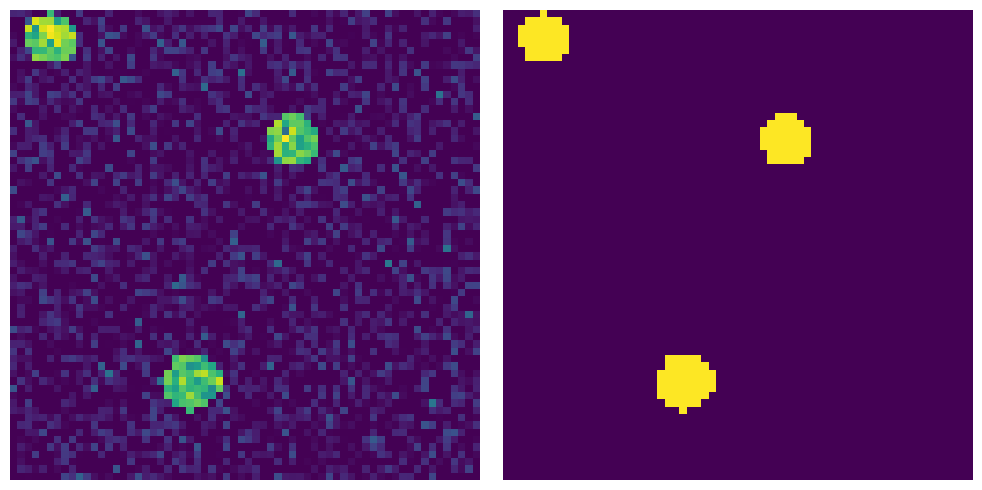

In [3]:
img_rows, img_cols, img_channels = 64, 64, 1
size = (img_rows, img_cols)
theta = 5
rmean = 4
rstd = 0.5
vmin = 15
vmax = 200
sigma = 30

# Image generation
synthetic_img = Data_Generator(size, theta, rmean, rstd, vmin, vmax, sigma)
img, img_truth = synthetic_img.generate()

# Display the generated images
fig, ax = plt.subplots(1, 2, figsize=(10, 5),sharex=True,sharey=True)
ax[0].imshow(img)
ax[1].imshow(img_truth)
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

*Question 1*. Use the code of the previous cell to generate a dataset of 2000 training image and 200 validation images. The dataset must be at a format compatible with keras (ex: numpy array)

In [4]:
nb_train_samples = 2000
X_train, Y_train = [], []

# Insert your code here
for i in range(nb_train_samples) :
  synthetic_img = Data_Generator(size, theta, rmean, rstd, vmin, vmax, sigma)
  img, img_truth = synthetic_img.generate()
  X_train.append(img)
  Y_train.append(img_truth)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

print('Generation of the training set completed')


Generation of the training set completed


In [5]:
nb_val_samples = 200
X_val, Y_val = [], []

# Insert your code here

for i in range(nb_val_samples) :
  synthetic_img = Data_Generator(size, theta, rmean, rstd, vmin, vmax, sigma)
  img, img_truth = synthetic_img.generate()
  X_val.append(img)
  Y_val.append(img_truth)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

print('Generation of the validation set completed')

Generation of the validation set completed


The code in the cell below display one of the training image.

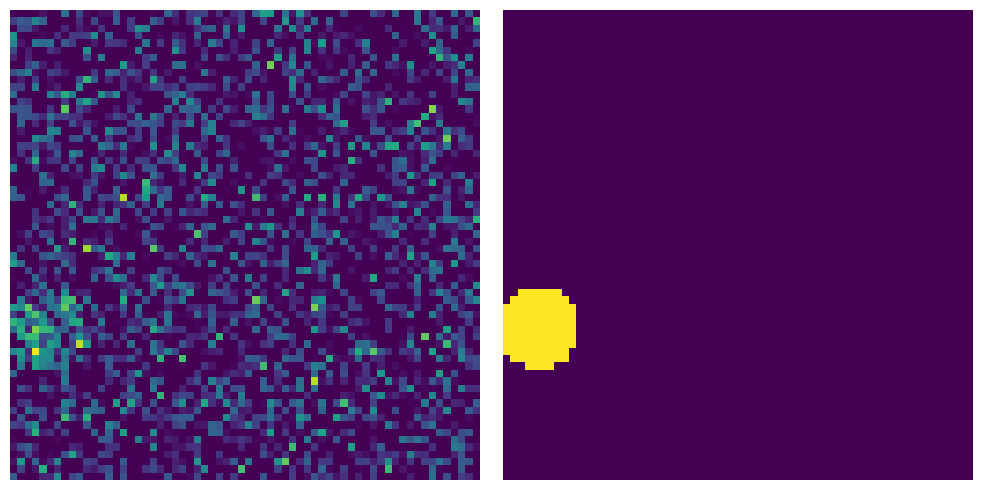

In [6]:
index = 4
fig, ax = plt.subplots(1, 2, figsize=(10, 5),sharex=True,sharey=True)
ax[0].imshow(X_train[index, :, :])
ax[1].imshow(Y_train[index, :, :])
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

## 2. Network Architecture

We use the Context Aggregation Network to perform the image segmentation. The particularity of this convolutional neural network is that it gradually aggregates contextual information without losing resolution through the use of dilated convolutions, whose field of view increases exponentially over the network layers.

The input image is normalized and goes through a set of layers $\{L^1, \cdots, L^d\}$. The output of the network is constituted of an image with one channel corresponding to the segmentation mask for the disks.

Each block $L^s$, $s\in [\![2,d-1]\!]$ is made of
1. a dilated convolution, with receptive field $ 3\times 3 $, depth $24$, dilation parameter $r_s=2^{s-1}$ and stride $1$,
2. a batch normalization layer
3. a leaky rectifier linear unit (LReLU), defined as
$ \Phi(x) = \max(0.2 x, x) $
as activation function.
Padding is applied to ensure that the output of the block has the same size as the input.

The final block of the network is composed of a 2D convolution with receptive field $1 \times 1$, depth $1$, stride $1$, dilation $1$ and uses a Sigmoid activation function.

*Question 2.* Implement the CAN architecture with Keras. Do not forget to include the normalization!

In [7]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU


def make_model(input_shape, nb_modules):

    """
    Creates the network architecture

    Parameters
    ----------

    input shape: tuple of ints
        shape of the input image
    nb_modules: int
        number of module

    Returns
    -------

    out: Keras model
        Keras model for the CAN architecture
    """

    # Insert your code here

    inputs = Input(shape=input_shape)
    x = keras.layers.Rescaling(1.0 /255)(inputs)
    for n in range(nb_modules) :
      x = Conv2D(filters=24, kernel_size=3, strides=1, padding='same', dilation_rate=1)(inputs)
      x = BatchNormalization()(x)
      x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=1, kernel_size=1, strides=1, padding='same')(x)
    outputs = keras.layers.Activation('sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=x)
    return model


input_shape = (64, 64, 1)
nb_layers = 6
model = make_model(input_shape, nb_layers)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 24)          │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 1)           │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 313 (1.22 KB)

 Non-trainable params: 48 (192.00 B)

## 3. Train the model

The code in the following cell trains the neural network architecture and plot the evolution of the training loss/validation loss according to the epochs.

In [8]:
# training
history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_val, Y_val),
                    verbose=True)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - loss: 0.2684 - val_loss: 0.0797
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0328 - val_loss: 0.0677
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0224 - val_loss: 0.0860
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0190 - val_loss: 0.0308
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 0.0178 - val_loss: 0.0355
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.0159 - val_loss: 0.0190
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0156 - val_loss: 0.0175
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 0.0148 - val_loss: 0.0202


In [9]:
# **** #####################################"
print("Best validation loss: %.5f" % (np.min(history.history['val_loss'])))
print("at: %d" % np.argmin(history.history['val_loss']))

Best validation loss: 0.01400
at: 8


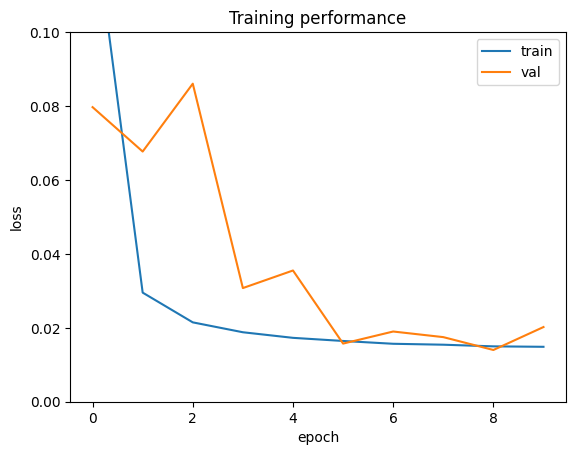

In [10]:
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.title('Training performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim(0.0, 0.1)
plt.show()

## 4: Test the model

*Question 3*. Generate a dataset of 10 test images and test the result of the algorithm on these images.


In [11]:
nb_test_samples = 10
X_test, Y_test = [], []

# Insert your code here

for i in range(nb_test_samples) :
  synthetic_img = Data_Generator(size, theta, rmean, rstd, vmin, vmax, sigma)
  img, img_truth = synthetic_img.generate()
  X_test.append(img)
  Y_test.append(img_truth)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

print('Generation of the test set completed')

Generation of the test set completed


In [14]:
# Insert your code here
model.evaluate(X_test, Y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0208


0.02077304758131504